Build a decision tree model that can predict the probability of heart disease occurrence, based on a combination of features that describes the disease. In order to achieve the goal, we used data sets that was collected by Cleveland Clinic Foundation in Switzerland. [Data achieve](https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/)

Follow the course, only add some data exploration (hence there is no train test split, etc)

In [75]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import decomposition, preprocessing, tree

# Read and Clean Data

## Load Data

In [29]:
feat_names = ["age", "sex", "cp", "trestpbs", "chol", "fbs", "restecg", "thalach", 
             "exang", "oldpeak", "slope", "ca", "thal"]
target_name = ["hear_disease_type"]
col_names = feat_names + target_name
col_names

['age',
 'sex',
 'cp',
 'trestpbs',
 'chol',
 'fbs',
 'restecg',
 'thalach',
 'exang',
 'oldpeak',
 'slope',
 'ca',
 'thal',
 'hear_disease_type']

In [8]:
heart_data = pd.read_csv("processed.cleveland.data.csv", header=None, names=col_names)
print heart_data.shape
heart_data.head()

(303, 14)


,age,sex,cp,trestpbs,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hear_disease_type
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


## Clean missing data 
(col ca and thal) --> drop rows since there are only a few of those records.

In [43]:
heart_data = heart_data[heart_data["ca"] != "?"]
heart_data["ca"] = heart_data["ca"].apply(float)
heart_data = heart_data[heart_data["thal"] != "?"]
heart_data["thal"] = heart_data["thal"].apply(float)
heart_data.shape

(297, 14)

## Normalised data

In [57]:
heart_data_normed_feat = pd.DataFrame()

In [63]:
def transform_one_feature(df_features, feature_name="payamo"):
    _vals = df_features[feature_name].astype(float).values.reshape(-1,1)
    _trans = preprocessing.StandardScaler()
    _vals_normed = _trans.fit_transform(_vals)    
    return _vals_normed

for _col in feat_names:
    heart_data_normed_feat[_col] = transform_one_feature(heart_data, feature_name=_col).reshape(-1)

Simplify the target from 5 classes to binary (there is heart disease or not)

In [76]:
heart_data_normed_feat[target_name] = heart_data[target_name].apply(lambda v: v > 0.5)
heart_data[target_name] = heart_data[target_name].apply(lambda v: v > 0.5)

In [80]:
heart_data.head(2)

,age,sex,cp,trestpbs,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hear_disease_type
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,False
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,True


In [79]:
heart_data_normed_feat.head(2)

,age,sex,cp,trestpbs,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hear_disease_type
0,0.936181,0.691095,-2.240629,0.750380,-0.276443,2.430427,1.010199,0.017494,-0.696419,1.068965,2.264145,-0.721976,0.655877,False
1,1.378929,0.691095,0.873880,1.596266,0.744555,-0.411450,1.010199,-1.816334,1.435916,0.381773,0.643781,2.478425,-0.894220,True


# Data Exploration

In [78]:
heart_data.describe()

,age,sex,cp,trestpbs,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,3.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,1.602694,0.676768,4.730640
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,0.938965,1.938629
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,3.000000
50%,56.000000,1.000000,3.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000
75%,61.000000,1.000000,4.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000


## Historgram and pair relationships

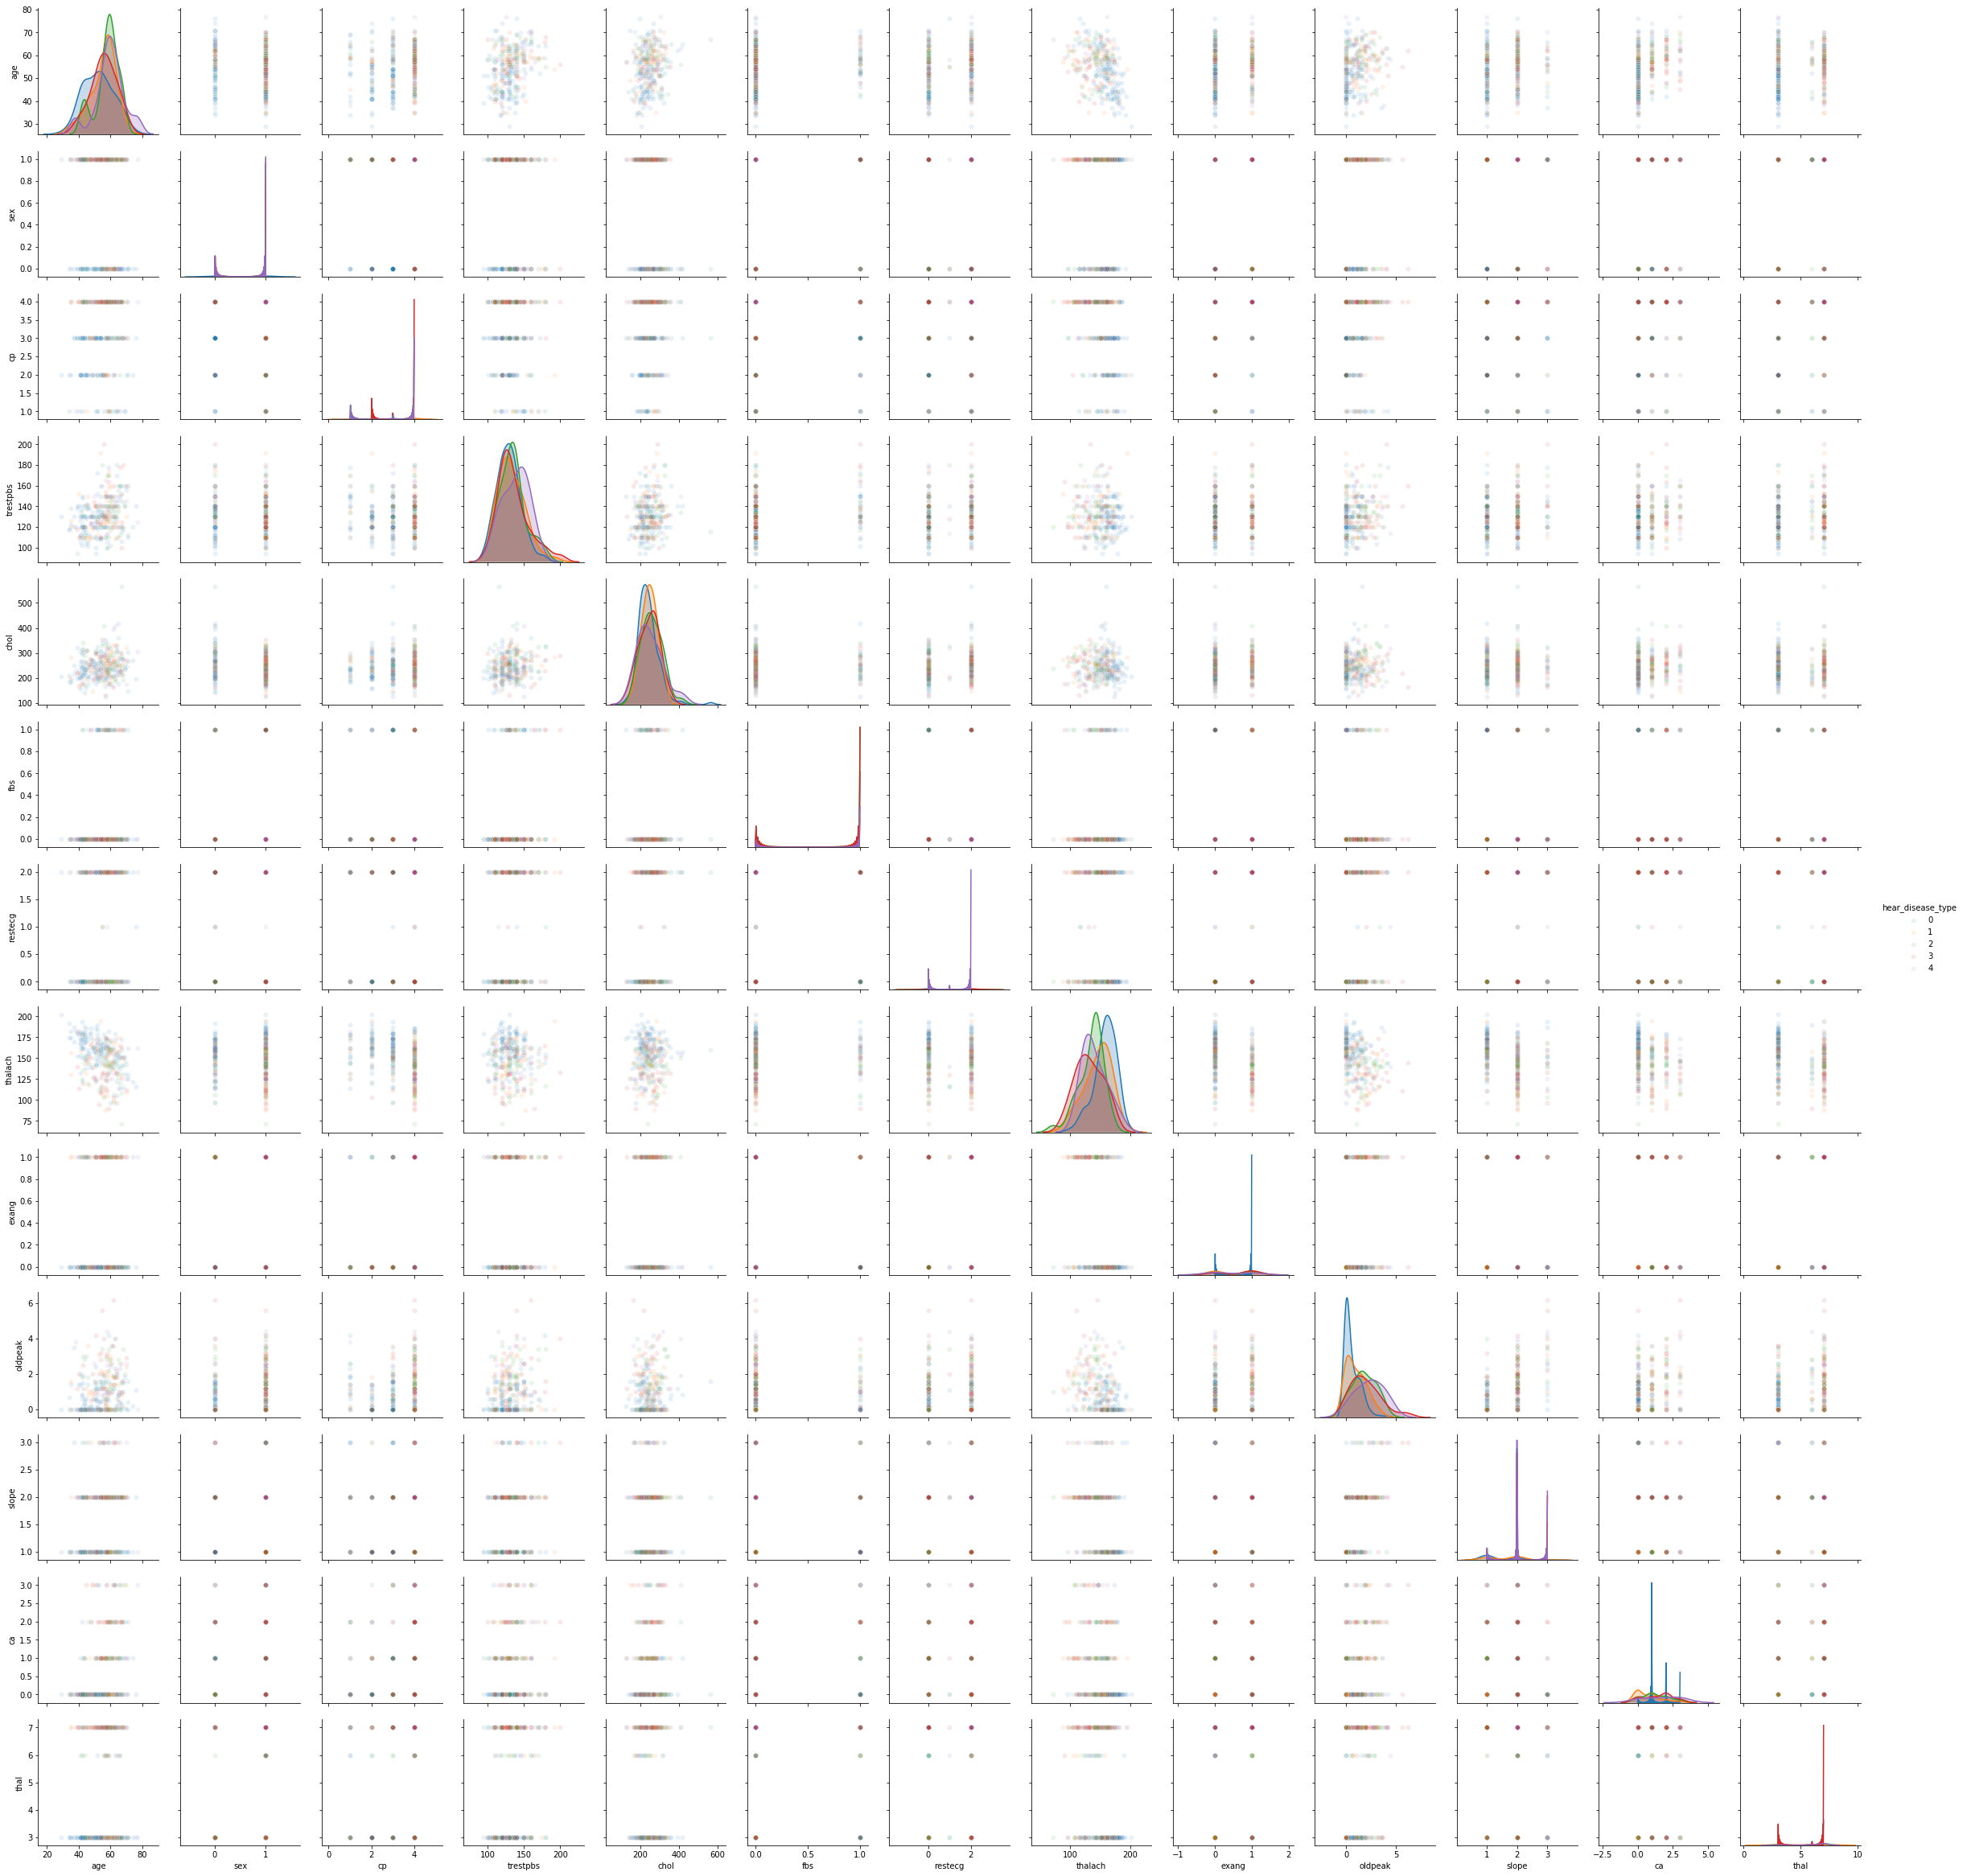

In [48]:
g = sns.pairplot(heart_data, 
                 vars = feat_names,
                 hue = "hear_disease_type",
                 plot_kws=dict(alpha=0.1)
                )

Looks like there are categorical data, e.g. sex, cp -- not sure if their current orders have any meaning --> ignore for now

## PCA 
to check linear dimentional reduction

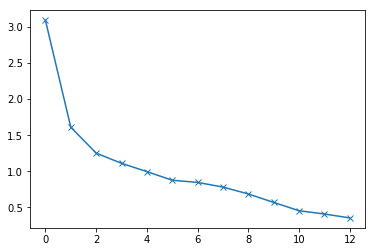

In [72]:
pca = decomposition.PCA()
pca.fit(heart_data_normed_feat[feat_names])
g = plt.plot(pca.explained_variance_, marker='x')

## Correlation matrix 

In [67]:
def plot_corr_matrix(df, corr_method="pearson"):
    #source: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
    
    # Compute the correlation matrix
    corr = df.corr(corr_method, min_periods=100)

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title(corr_method)
    plt.show()

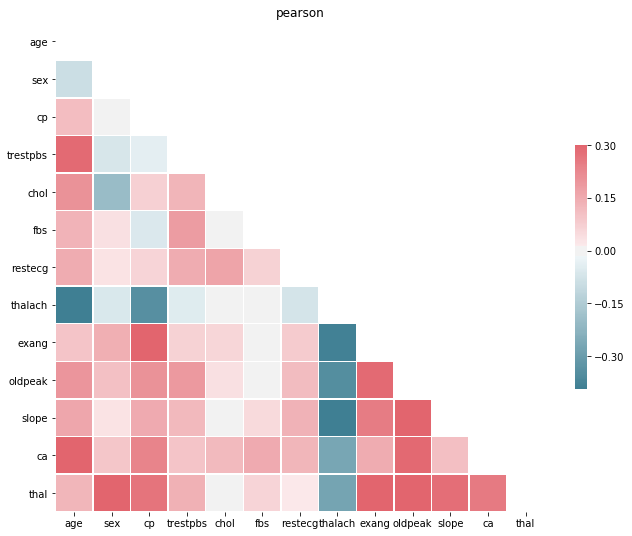

In [73]:
plot_corr_matrix(heart_data_normed_feat)

# Build Decision Tree

In [81]:
heart_data.head(2)

,age,sex,cp,trestpbs,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hear_disease_type
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,False
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,True


In [86]:
X = heart_data.loc[:, heart_data.columns != "hear_disease_type"]  # this way to select columns is new to me
Y = heart_data.loc[:, target_name]

In [88]:
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X, Y)

In [97]:
clf.score(X, Y)

0.85521885521885521

Visualise the tree

In [92]:
with open("heart.dot", "w") as f:
    f_res = tree.export_graphviz(clf, out_file=f, feature_names=feat_names, 
                                 class_names=["on_disease", "disease"],
                                 filled = True
                                )

In [ ]:
! dot -Tpng heart.dot -o heart.png

![Image of tree model](heart.png)

In [101]:
clf.feature_importances_

array([ 0.        ,  0.        ,  0.22914924,  0.04758692,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.0486324 ,
        0.        ,  0.17575543,  0.49887601])

This tree contains repeated pathes, e.g. (ca and cp at level 1 and 2)

# Build Bot
using the decision tree model

In [134]:
def traverse_tree(left, right, threshold, feature, value, target_names, node, depth): 
    if left[node] != -1: # not the leaf of a binary tree
        val = input("Depth = %d, Input value of %s :" % (depth, feature[node]))
        if val <= threshold[node]:
            traverse_tree(left, right, threshold, feature, value, target_names, left[node], depth+1)
        else:
            traverse_tree(left, right, threshold, feature, value, target_names, right[node], depth+1)            
    else:
        print "depth = ", depth
        res = target_names[np.argmax(value[node])]
        print "Your diagnosis: ", res

In [135]:
traverse_tree(clf.tree_.children_left,
              clf.tree_.children_right,
              clf.tree_.threshold,
              [feat_names[i] if i > 0 else "_" for i in clf.tree_.feature],
              clf.tree_.value,
              ["no heart disease", "heart disease"],
              0,
              0
             )

Depth = 0, Input value of thal :5
Depth = 1, Input value of cp :4
Depth = 2, Input value of oldpeak :0.5
depth =  3
Your diagnosis:  heart disease


+ Interesting technique
+ Can make the conclution more contextual, e.g. how many patients we see that, etc